In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16, MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

2024-08-05 20:13:29.824440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 20:13:29.985768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 20:13:30.087125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 20:13:30.110696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 20:13:30.246334: I tensorflow/core/platform/cpu_feature_guar

In [2]:
warnings.filterwarnings("ignore")

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7*1024)]) 
    except RuntimeError as e:
        print(e)

In [6]:
image_path = 'data/asl_alphabet_train/asl_alphabet_train/'
models_path = 'models/asl_model.keras'
preprocessing_path = 'data/preprocessing/train/'
rgb = False
imageSize = 224

In [7]:
gestures = { chr(i): i - 65 for i in range(65,91)}
# gestures = { chr(i): i - 65 for i in range(65,75)}
gestures['space'] = len(gestures)

In [8]:
gestures.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space'])

In [12]:
def preprocessing_image(gesture, imageSize, rgb):
    if not os.path.exists(f'{preprocessing_path}{gesture}'):
        os.makedirs(f'{preprocessing_path}{gesture}')
    for f in os.listdir(f'{image_path}{gesture}'):
        image = Image.open(f'{image_path}{gesture}/{f}')
        if not rgb:
            image_gray = image.convert("L")
        else:
            image_gray = image.copy()
            
        image_gray.resize((imageSize,imageSize))
        image_gray.save(f'{preprocessing_path}{gesture}/{f}', optimize=True)
        image_gray.close()

In [13]:
for gesture in gestures: 
    preprocessing_image(gesture, 224, True)

In [14]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((imageSize, imageSize))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    # if rgb:
    #     pass
    # else:
    #     X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def load_dataset(image_path, gestures, size):
    X_data = []
    y_data = []

    for x in gestures.keys():
        for f in os.listdir(f'{image_path}{x}')[:size]:
            X_data.append(process_image(f'{image_path}{x}/{f}'))
            y_data.append(gestures[x])
    

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [15]:
X, y = load_dataset(image_path=preprocessing_path, gestures=gestures, size=150)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [15]:
model_checkpoint = ModelCheckpoint(filepath=models_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)

In [17]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape = [imageSize, imageSize, 3]))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dense(units=len(gestures), activation='softmax'))



I0000 00:00:1722899947.485874   10050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722899947.489596   10050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722899947.492827   10050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722899947.594393   10050 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [18]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1, 
                    #callbacks=[early_stopping, model_checkpoint]
                    )


Epoch 1/10


I0000 00:00:1722900032.989891   16707 service.cc:146] XLA service 0x7f1f10003250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722900032.989965   16707 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-05 20:20:33.039232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-05 20:20:33.199265: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-05 20:20:40.854107: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng26{k2=0,k4=2,k5=1,k6=0,k7=0,k19=1} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"ope

101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.0434 - loss: 3.3729

2024-08-05 20:21:46.537668: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f32[8,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,224,224]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-05 20:21:47.263234: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.725632723s
Trying algorithm eng2{k2=1,k3=0} for conv (f32[8,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,224,224]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.0436 - loss: 3.3719

2024-08-05 20:22:06.990979: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-05 20:22:07.006956: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.016159735s
Trying algorithm eng0{} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

102/102 ━━━━━━━━━━━━━━━━━━━━ 108s 624ms/step - accuracy: 0.0437 - loss: 3.3709 - val_accuracy: 0.1654 - val_loss: 2.8895
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.3891 - loss: 2.1098 - val_accuracy: 0.7235 - val_loss: 1.0409
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.7933 - loss: 0.6912 - val_accuracy: 0.8741 - val_loss: 0.4706
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.9293 - loss: 0.2116 - val_accuracy: 0.8420 - val_loss: 0.5692
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9331 - loss: 0.2093 - val_accuracy: 0.9235 - val_loss: 0.3275
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9704 - loss: 0.0938 - val_accuracy: 0.9531 - val_loss: 0.2625
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9799 - loss: 0.0604 - val_accuracy: 0.9444 - val_loss: 0.2281
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.9848 - loss: 0.0544 - va

In [20]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9745 - loss: 0.1820


In [21]:
accuracy

0.9728395342826843

In [36]:
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [39]:
y_pred=[np.argmax(y) for y in y_pred]

In [41]:
y_test=[np.argmax(y) for y in y_test]

In [43]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

acc_cm = accuracy_score(y_test, y_pred)
print(acc_cm)

[[29  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1 28  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  2  0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 29  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  

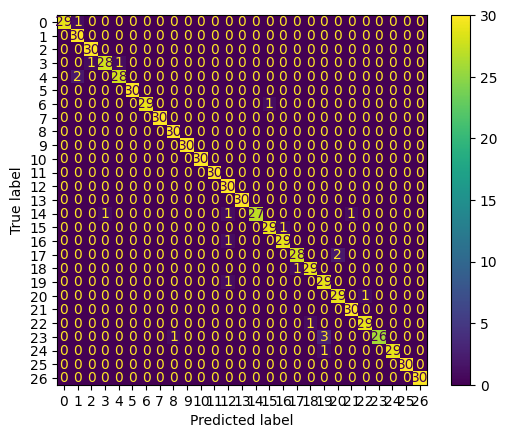

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,277,875 (294.79 MB)

 Trainable params: 25,759,291 (98.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,518,584 (196.53 MB)

In [46]:
test_path = "data/test/"

In [63]:
def preprocessing_image_test(test_path, imageSize, rgb):
    for f in sorted(os.listdir(f'{test_path}')):
        if ".jpg" not in f:
            continue
        image = Image.open(f'{test_path}{f}')
        if not rgb:
            image_gray = image.convert("L")
        else:
            image_gray = image.copy()
            
        image_gray.resize((imageSize,imageSize))
        image_gray.save(f'{test_path}preprocessing/{f}', quality=50, optimize=True)
        image_gray.close()

In [64]:
preprocessing_image_test(test_path,  224, True)

In [68]:
def load_dataset_test(image_path):
    X_data = []
    y_data = []

    for f in sorted(os.listdir(image_path)):
        X_data.append(process_image(f'{image_path}/{f}'))
        y_data.append(0)
    

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [69]:
X_, y_ = load_dataset_test(image_path=f'{test_path}preprocessing/')

In [70]:
y_pred = model.predict(X_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [71]:
for l in y_pred:
    print(list(gestures.keys())[np.argmax(l)])

M
B
A
space
U
N
I
F
O
R


In [58]:
gestures

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'space': 26}